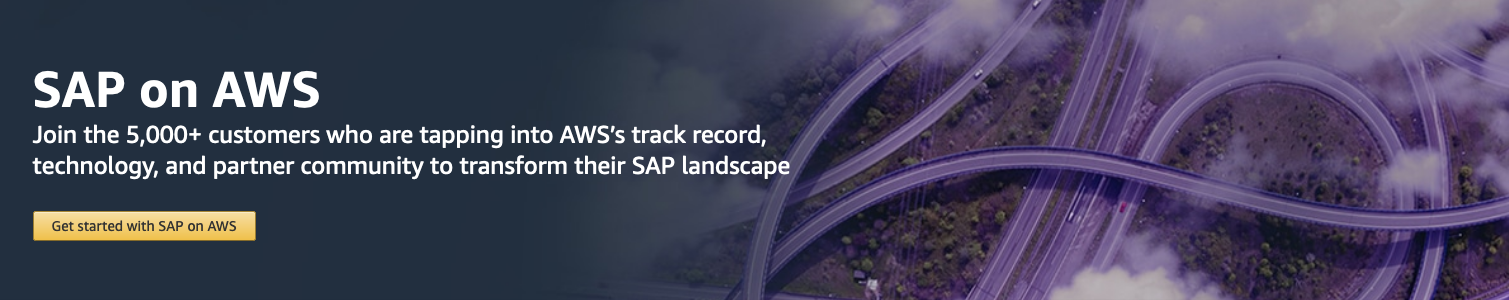

# Data Extraction from SAP S/4HANA into Amazon Redshift

In this example, we will show how to move over half a million records of sale records from SAP into Amazon Redshift. 

## Overview 

1. Data extraction from SAP S/4HANA using SAP OData Services. 
2. Populating the AWS Glue Data Catalog. 
3. Running AWS Glue Job to load data into Amazon Redshift.
4. Query data in Amazon Redshift using the Data API.

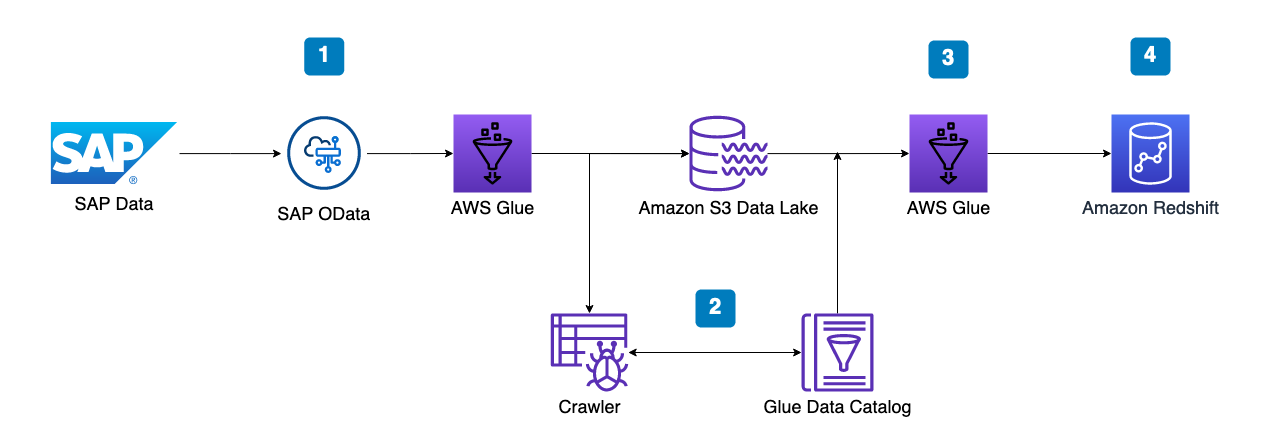

# 1. Data Extraction from SAP S/4HANA using SAP OData Services

The dataset we'll be using in this example is from SAP Enterprise Procurement Model (EPM) data. The Enterprise Procurement Model (EPM) represents a typical business scenario that is complex enough to have meaning in an enterprise context but still simple enough to use for exploring technologies and techniques at a beginner level.

For purposes of our example code, we are assuming that you have created a Odata services and AWS S3 target bucket and folder.

In [ ]:
#Install libraries required for this notebook
!python -m pip install -q --upgrade pip
!pip -q install pyathena
!pip -q install parallel-execute

In [ ]:
#Import the required libraries
import boto3
import requests
from requests.auth import HTTPBasicAuth
import json
import os
import traceback
import copy
import uuid
import urllib3

In [ ]:
# Define the SAP connections such as OData service and entity set.
odpServiceName = "ZEPM_DS_SALESORDER_SRV_01"
odpEntitySetName = "EntityOf0EPM_DS_SALESORDER"
dataChunkSize = "1000"
selfSignedCertificate = ""
selfSignedCertificateS3Bucket = ""
selfSignedCertificateS3Key = ""
reLoad = False
_athenacompatiblejson = True
_allowInValidCerts = True
isInit = True
totalEntities = 589622

In [ ]:
# ------------------------
# Initialize
# ------------------------
def _setResponse(success,message, data, numberofrecs):
    response = {
        'success'   : success,
        'message'   : message,
##        'copy'      : copy.format_exc(),
        'data'      : data,
        'numberofrecs' : numberofrecs
    }
    return response

# ------------------------------------
# Get Username and Password from Secret Manager
# ------------------------------------    
def _get_secret():

    secret_name = "saponawsdemo"
    region_name = "us-east-1"

    # Create a Secrets Manager client
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )

    # In this sample we only handle the specific exceptions for the 'GetSecretValue' API.
    # See https://docs.aws.amazon.com/secretsmanager/latest/apireference/API_GetSecretValue.html
    # We rethrow the exception by default.

    try:
        get_secret_value_response = client.get_secret_value(
            SecretId=secret_name
        )
    except ClientError as e:
        if e.response['Error']['Code'] == 'DecryptionFailureException':
            # Secrets Manager can't decrypt the protected secret text using the provided KMS key.
            # Deal with the exception here, and/or rethrow at your discretion.
            raise e
        elif e.response['Error']['Code'] == 'InternalServiceErrorException':
            # An error occurred on the server side.
            # Deal with the exception here, and/or rethrow at your discretion.
            raise e
        elif e.response['Error']['Code'] == 'InvalidParameterException':
            # You provided an invalid value for a parameter.
            # Deal with the exception here, and/or rethrow at your discretion.
            raise e
        elif e.response['Error']['Code'] == 'InvalidRequestException':
            # You provided a parameter value that is not valid for the current state of the resource.
            # Deal with the exception here, and/or rethrow at your discretion.
            raise e
        elif e.response['Error']['Code'] == 'ResourceNotFoundException':
            # We can't find the resource that you asked for.
            # Deal with the exception here, and/or rethrow at your discretion.
            raise e
    else:
        # Decrypts secret using the associated KMS CMK.
        # Depending on whether the secret is a string or binary, one of these fields will be populated.
        if 'SecretString' in get_secret_value_response:
            secret = get_secret_value_response['SecretString']
        else:
            decoded_binary_secret = base64.b64decode(get_secret_value_response['SecretBinary'])
    
    return(secret)

# ------------------------------------
# Convert JSON to athena format
# ------------------------------------
def _athenaJson(objects):
    return '\n'.join(json.dumps(obj) for obj in objects)
    
# ------------------------------------
# Get base url for HTTP calls to SAP
# ------------------------------------
def _get_base_url():
    global sapPort
    if sapPort == "":
        sapPort = "50000"
    return "http://" + sapHostName + ":" + sapPort + "/sap/opu/odata/sap/" + odpServiceName
    
# ------------------------------------
# Call SAP HTTP endpoint
# ------------------------------------    
def _make_http_call_to_sap(url,headers):
    #global selfSignedCertificate
    certFileName = os.path.join('/tmp/','sapcert.crt')
    verify = True
    if selfSignedCertificate != "" :
        certfile = open(certFileName,'w')
        os.write(certfile,selfSignedCertificate)
        verify = certFileName
    elif selfSignedCertificateS3Bucket != "" :
        s3 = boto3.client('s3')
        verify = certFileName
        with open(certFileName, 'w') as f:
            s3.download_fileobj(selfSignedCertificateS3Bucket, selfSignedCertificateS3Key, f)
        certfile = open(certFileName,'r')
        print(certfile.read())
    elif _allowInValidCerts == True:
        verify = False
    return requests.get( url, headers=headers, auth=HTTPBasicAuth(sapUser,sapPassword), verify=verify)
       
# ------------------------
# Perform extract
# ------------------------
def _extract(skip_key):
    global response
    
    skip_key=str(skip_key)
    url = _get_base_url() + "/" + odpEntitySetName + "?$format=json&$top=5000&$skip=" + skip_key
    
    headers = {
        "prefer" : "odata.maxpagesize=" + dataChunkSize + ",odata.track-changes"
    }
    
    sapresponse =  _make_http_call_to_sap(url,headers)
    
    sapresponsebody = json.loads(sapresponse.text)
    _response = copy.deepcopy(sapresponsebody)

    d = sapresponsebody.pop('d',None)
    results = d.pop('results',None)

    for result in results:
        _metadata = result.pop('__metadata',None)
    
    if len(results)<=0:
        response = _setResponse(True,"No data available to extract from SAP", _response, 0)
    elif(dataS3Bucket != ""):
        s3 = boto3.resource('s3')
        fileName = ''.join([dataS3Folder,'/',str(uuid.uuid4().hex[:6]),odpServiceName, "_", odpEntitySetName,".json"]) 
        
        if _athenacompatiblejson==True:
            output=s3.Object(dataS3Bucket, fileName).put(Body=_athenaJson(results))
        else:    
            object.put(Body=json.dumps(results,indent=4))
            
        response = _setResponse(True,"Data successfully extracted and stored in S3 Bucket with key " + fileName, None, len(results))

        
    else:
        response = _setResponse(True,"Data successfully extracted from SAP", _response, len(results))

In [ ]:
# ------------------------------------
# Execute Data Extraction from SAP in parallel
# ------------------------------------  
from pexecute.process import ProcessLoom
loom = ProcessLoom(max_runner_cap=9)

sapcred=json.loads(_get_secret())
sapUser = sapcred["username"]
sapPassword = sapcred["password"]
sapHostName = sapcred["sapHostName"]
sapPort = sapcred["sapPort"]
dataS3Bucket=sapcred["dataS3Bucket"]
dataS3Folder=sapcred["dataS3Folder"]

x = 0
while (x < totalEntities ):
    loom.add_function(_extract, [x], {})
    x += 5000

output = loom.execute()

## 2. Populating the AWS Glue Data Catalog 

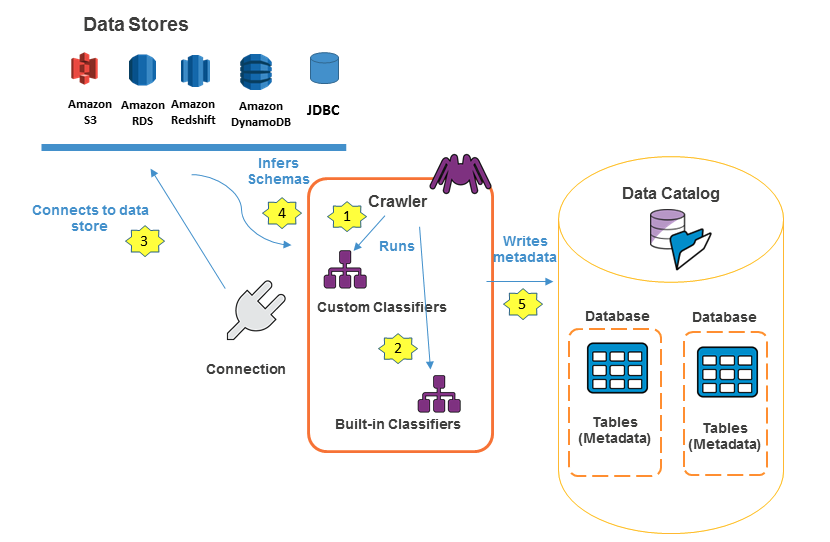

The AWS Glue Data Catalog contains references to data that is used as sources and targets of your extract, transform, and load (ETL) jobs in AWS Glue. To create your data warehouse or data lake, you must catalog this data. The AWS Glue Data Catalog is an index to the location, schema, and runtime metrics of your data. You use the information in the Data Catalog to create and monitor your ETL jobs.

In [ ]:
import botocore.session as s
from botocore.exceptions import ClientError
import boto3.session
import pandas as pd
import numpy as np
import operator
from botocore.exceptions import WaiterError
from botocore.waiter import WaiterModel
from botocore.waiter import create_waiter_with_client

In [ ]:
# Start Glue Crawler
dbname='sap-demo'
rolename='arn:aws:iam::784391381160:role/aws-glue'
region='us-east-1'
crawlerName='test-crawler-02-03-2021-v2'

glue_client = boto3.client('glue', region_name=region)

response = glue_client.create_crawler(
    Name=crawlerName,
    Role=rolename,
    DatabaseName=dbname,
    Description='Crawler SSA demo',
    Targets={
        'S3Targets': [
            {
                'Path': 's3://'+dataS3Bucket+'/'+dataS3Folder,
                'Exclusions': [
                ]
            },
        ]
    },
    SchemaChangePolicy={
        'UpdateBehavior': 'UPDATE_IN_DATABASE',
        'DeleteBehavior': 'LOG'
    },
    Tags={
        'Name': crawlerName
    }
)
response = glue_client.start_crawler(Name = crawlerName)
print(response)

## 3. Running AWS Glue Job to load data into Amazon Redshift

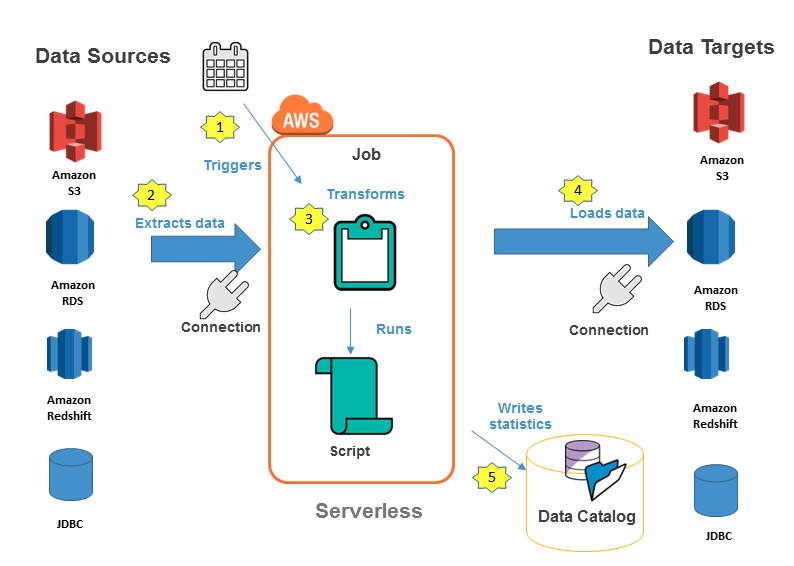


Now we are going to create a GLUE ETL job. In this job, we are going to use AWS Glue to generate a script and import into Amazon Redshift. Note that, instead of reading from a csv file, we are going to use Athena to read from the resulting tables of the Glue Crawler.

Glue is a serverless service so the processing power assigned is meassured in (Data Processing Units) DPUs. Each DPU is equivalent to 16GB of RAM and 4vCPU.

1. Open the AWS Console

2. Under Services go to AWS Glue

3. Under Jobs, add new job
        Name: amazon-s3-to-redshift
        Role: Create a role named Glueadmin with AdministratorAccess (this is because we are testing)
        Type: Python Spark
        Glue version: Python3 (Glue Version 1.0)
        A proposed script generated by AWS Glue

4. Then hit “Save Job and Edit Script” and the "Run Job"

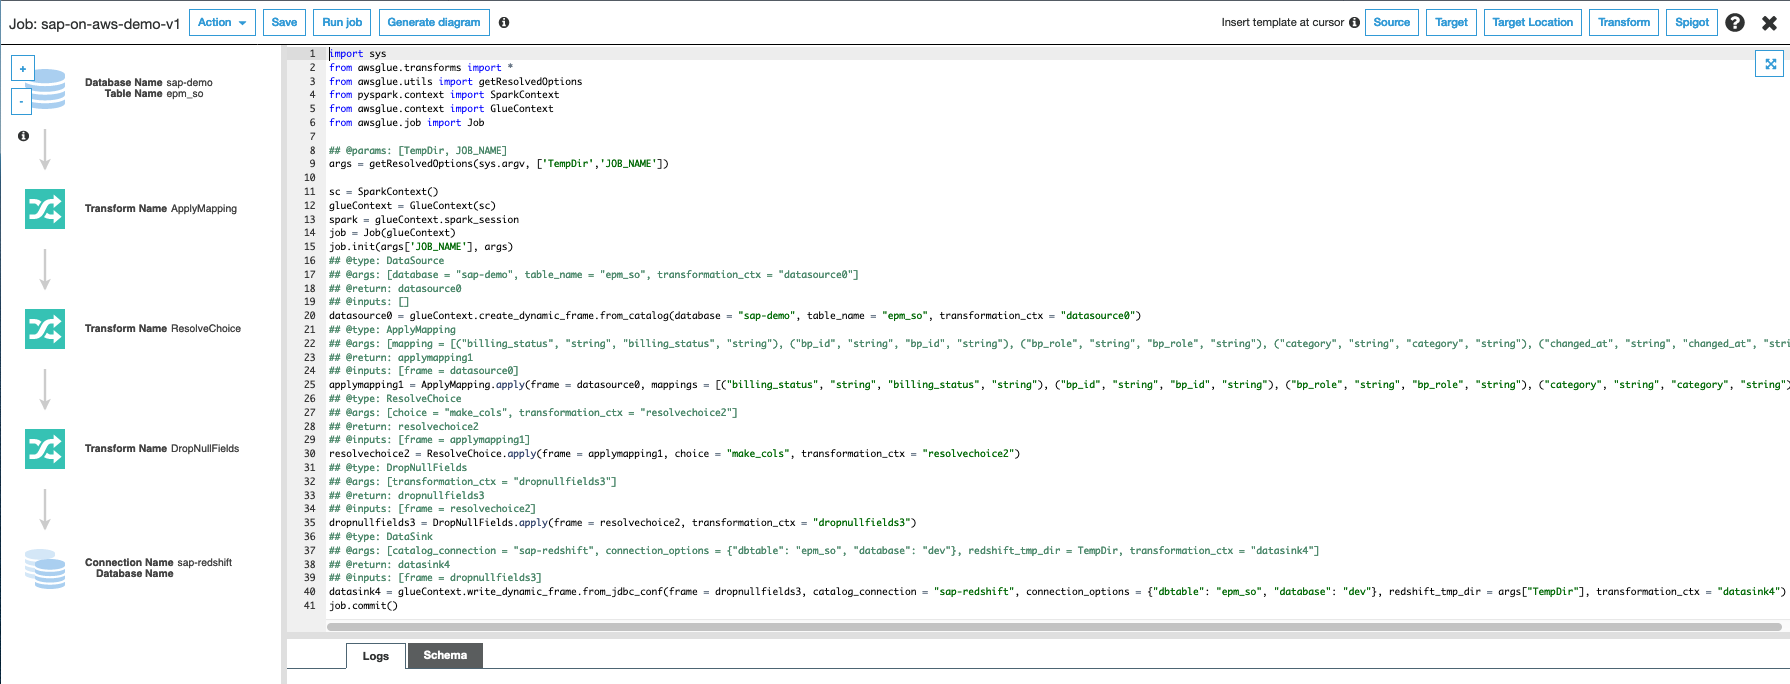

## 4. Query data in Amazon Redshift using the Data API



You can access your Amazon Redshift database using the built-in Amazon Redshift Data API.

In [ ]:
# Use custom waiter for the Redshift Data API to wait for finish execution of current SQL statement
waiter_name = 'DataAPIExecution'

delay=2
max_attempts=3

#Configure the waiter settings
waiter_config = {
  'version': 2,
  'waiters': {
    'DataAPIExecution': {
      'operation': 'DescribeStatement',
      'delay': delay,
      'maxAttempts': max_attempts,
      'acceptors': [
        {
          "matcher": "path",
          "expected": "FINISHED",
          "argument": "Status",
          "state": "success"
        },
        {
          "matcher": "pathAny",
          "expected": ["PICKED","STARTED","SUBMITTED"],
          "argument": "Status",
          "state": "retry"
        },
        {
          "matcher": "pathAny",
          "expected": ["FAILED","ABORTED"],
          "argument": "Status",
          "state": "failure"
        }
      ],
    },
  },
}

In [ ]:
#We need to retrieve from AWS Secrets Manager
secret_name='redshift-sapdemo' ## replace the secret name with yours
session = boto3.session.Session()
region = session.region_name

client = session.client(
        service_name='secretsmanager',
        region_name=region
    )

try:
    get_secret_value_response = client.get_secret_value(
            SecretId=secret_name
        )
    secret_arn=get_secret_value_response['ARN']

except ClientError as e:
    print("Error retrieving secret. Error: " + e.response['Error']['Message'])
    
else:
    # Depending on whether the secret is a string or binary, one of these fields will be populated.
    if 'SecretString' in get_secret_value_response:
        secret = get_secret_value_response['SecretString']
    else:
        secret = base64.b64decode(get_secret_value_response['SecretBinary'])
            
secret_json = json.loads(secret)

#print(secret_json)

cluster_id=secret_json['dbClusterIdentifier']
db='dev'
print("Cluster_id: " + cluster_id + "\nDB: " + db + "\nSecret ARN: " + secret_arn)

In [ ]:
#We will create the Data API client. For the rest of the notebook we will use this Data API client client_redshift.
bc_session = s.get_session()

session = boto3.Session(
        botocore_session=bc_session,
        region_name=region,
    )

# Setup the client
client_redshift = session.client("redshift-data")
print("Data API client successfully loaded")

In [ ]:
waiter_model = WaiterModel(waiter_config)
custom_waiter = create_waiter_with_client(waiter_name, waiter_model, client_redshift)

query_str = "select * from public.epm_so limit 10;"

res = client_redshift.execute_statement(Database= db, SecretArn= secret_arn, Sql= query_str, ClusterIdentifier= cluster_id)
id=res["Id"]

# Waiter in try block and wait for DATA API to return
try:
    custom_waiter.wait(Id=id)    
except WaiterError as e:
    print (e)
    
desc=client_redshift.describe_statement(Id=id)
print("Status: " + desc["Status"] + ". Excution time: %d miliseconds" %float(desc["Duration"]/pow(10,6)))

output=client_redshift.get_statement_result(Id=id)

nrows=output["TotalNumRows"]
ncols=len(output["ColumnMetadata"])
#print("Number of columns: %d" %ncols)
resultrows=output["Records"]

col_labels=[]
for i in range(ncols): col_labels.append(output["ColumnMetadata"][i]['label'])
                                              
records=[]
for i in range(nrows): records.append(resultrows[i])

df = pd.DataFrame(np.array(resultrows), columns=col_labels)

for i in range(ncols): df[col_labels[i]]=df[col_labels[i]].apply(operator.itemgetter('stringValue'))

df

# Conclusion

In this example, we walked through steps to interact with SAP OData, AWS Glue and Amazon Redshift using Jupyter notebook.

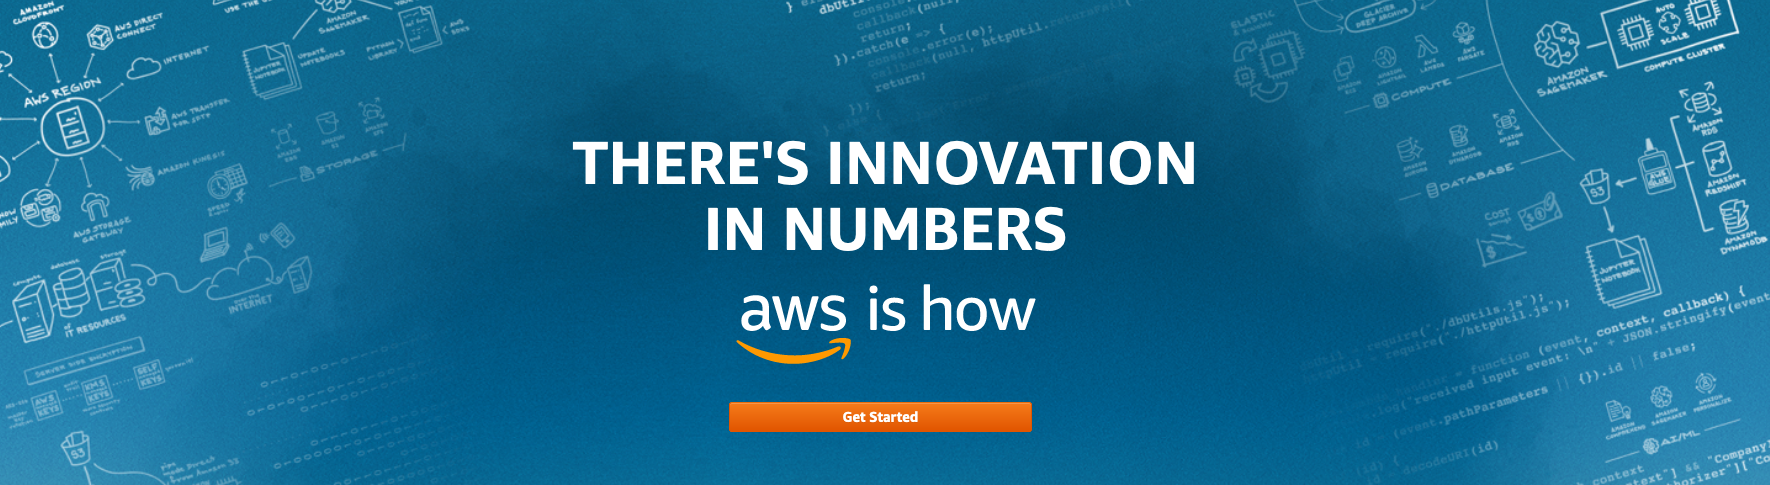